## Use stacked images (3D) and Densenet121 3D model

Acknowledgements:

- https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
- https://www.kaggle.com/davidbroberts/determining-dicom-image-order
- https://www.kaggle.com/ihelon/brain-tumor-eda-with-animations-and-modeling
- https://www.kaggle.com/furcifer/torch-efficientnet3d-for-mri-no-train
- https://github.com/shijianjian/EfficientNet-PyTorch-3D

This notebook is based on the implementation of Densenet121 3D available here:
https://www.kaggle.com/mikecho/monai-v060-deep-learning-in-healthcare-imaging

It builds 4 models with only one MRI type, then ensembles all of them computing average probabilities


In [1]:
import os
import sys 
import json
import glob
import random
import re
import collections
import time
from pathlib import Path

import numpy as np
import pandas as pd
import pydicom
import cv2
import skimage
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional

import torchio as tio
import nibabel as nib

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb

In [2]:
if os.path.exists("/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"):
    data_directory = "/kaggle/input/rsna-miccai-brain-tumor-radiogenomic-classification"
    input_monaipath = "/kaggle/input/monai-v060-deep-learning-in-healthcare-imaging/"
    landmarks_directory = "/kaggle/input/rsna-landmarks"
else:
    data_directory = "rsna-miccai-brain-tumor-radiogenomic-classification"
    input_monaipath = "MONAI"
    landmarks_directory = "rsna-landmarks"

processed_data_dir = 'rsna-preprocessed'
experiment_folder = "experiments/patch_seresnext50_3fold_stacking"
model_paths = f"{experiment_folder}/models"


In [3]:
os.makedirs(experiment_folder, exist_ok=True)

In [4]:
mri_types = ['FLAIR', 'T1w', 'T1wCE', 'T2w']

SIZE = 512
NUM_IMAGES = 64
BATCH_SIZE = 2
PATCH_SIZE = (128, 128, 96)

# EPOCHS = 10
# MIN_LR = 1e-6
# LR = 0.001
EPOCHS = 10
LR = 1e-3

NUM_FOLDS = 3
SEED = 42

sys.path.append(input_monaipath)

# worked well ?
# from monai.networks.nets.densenet import DenseNet121
# failed
# from monai.networks.nets.vit import ViT
from monai.networks.nets.senet import SEResNext50


In [5]:
TOTAL_EPOCHS = EPOCHS * len(mri_types) * NUM_FOLDS
TOTAL_EPOCHS

120

## Preprocess Dataset

In [6]:
preprocessing_transforms = (
    tio.ToCanonical(),
    tio.Resample(1, image_interpolation='bspline'),
    tio.Resample('T1w', image_interpolation='nearest'),
)
preprocess = tio.Compose(preprocessing_transforms)

In [7]:
train_set = tio.datasets.RSNAMICCAI(data_directory, train=True, transform=preprocess)
test_set = tio.datasets.RSNAMICCAI(data_directory, train=False, transform=preprocess)

In [8]:
def preprocess_dataset(dataset, out_dir, parallel=True):
    import shutil
    import multiprocessing as mp
    from pathlib import Path
    from tqdm.notebook import tqdm
    out_dir = Path(out_dir)
    labels_name = 'train_labels.csv'
    out_dir.mkdir(exist_ok=True, parents=True)
    shutil.copy(dataset.root_dir / labels_name, out_dir / labels_name)
    subjects_dir = out_dir / ('train' if dataset.train else 'test')
    if parallel:
        loader = torch.utils.data.DataLoader(
            dataset,
            num_workers=mp.cpu_count(),
            collate_fn=lambda x: x[0],
        )
        iterable = loader
    else:
        iterable = dataset
    for subject in tqdm(iterable):
        subject_dir = subjects_dir / subject.BraTS21ID
        for name, image in tqdm(subject.get_images_dict().items(), leave=False):
            image_dir = subject_dir / name
            image_dir.mkdir(exist_ok=True, parents=True)
            image_path = image_dir / f'{name}.nii.gz'
            image.save(image_path)


In [9]:
%%time

if not Path(processed_data_dir).is_dir():
    preprocess_dataset(train_set, processed_data_dir)
    preprocess_dataset(test_set, processed_data_dir)

CPU times: user 109 µs, sys: 84 µs, total: 193 µs
Wall time: 149 µs


In [10]:
processed_data_dir = 'rsna-preprocessed'

## Functions to load images

In [11]:
def load_preprocessed_data_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train"):
    path = f"{processed_data_dir}/{split}/{scan_id}/{mri_type}/{mri_type}.nii.gz"
    data = nib.load(path).get_fdata()
    
    # img_count = data.shape[-1]
    # every_nth = img_count / num_imgs
    # indexes = [min(int(round(i * every_nth)), img_count - 1) for i in range(0, num_imgs)]
    # data = data[:, :, indexes]
    # data = cv2.resize(data, (SIZE, SIZE))
    
    data = np.expand_dims(data, axis=0)
    return data

load_preprocessed_data_3d("00000", mri_type=mri_types[0]).shape

(1, 241, 241, 165)

In [12]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(SEED)

## remove samples as described in https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/262046

In [13]:
samples_to_exclude = [109, 123, 709]

df = pd.read_csv(f"{data_directory}/train_labels.csv")
print("original shape", df.shape)
df = df[~df.BraTS21ID.isin(samples_to_exclude)]
print("new shape", df.shape)
display(df)

original shape (585, 2)
new shape (582, 2)


,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


In [14]:
# df = df.iloc[:16]

## Model and training classes

In [15]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, landmarks_dict=None, split="train"):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.landmarks_dict = landmarks_dict
        self.split = split
          
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_preprocessed_data_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split) # augs = [
            hs = np.array(PATCH_SIZE) // 2
            x = int(np.random.uniform(hs[0], data.shape[1] - hs[0]))
            y = int(np.random.uniform(hs[1], data.shape[2] - hs[1]))
            z = int(np.random.uniform(hs[2], data.shape[3] - hs[2]))
            data = data[:, x-hs[0]:x+hs[0], y-hs[1]:y+hs[1], z-hs[2]:z+hs[2]]
        else:
            data = load_preprocessed_data_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train")
            augs = [
                # TODO: tio.RandomFlip(axes=(0)),
                tio.RandomBlur(p=0.15),                    # blur 15% of times
                tio.RandomNoise(p=0.15),                   # noise 15% of times
                tio.RandomAffine(p=0.4),                   # affine transforms applied to 40% of images
                tio.RandomBiasField(p=0.2),                # magnetic field inhomogeneity 20% of times
                tio.OneOf({                                # either
                    tio.RandomMotion(): 1,                 # random motion artifact
                    tio.RandomSpike(): 2,                  # or spikes
                    tio.RandomGhosting(): 2,               # or ghosts
                }, p=0.2),                                 # applied to 20% of images
            ]
            transforms = tio.Compose(augs)
            data = transforms(data)
            
            hs = np.array(PATCH_SIZE) // 2
            x = int(np.random.uniform(hs[0], data.shape[1] - hs[0]))
            y = int(np.random.uniform(hs[1], data.shape[2] - hs[1]))
            z = int(np.random.uniform(hs[2], data.shape[3] - hs[2]))
            data = data[:, x-hs[0]:x+hs[0], y-hs[1]:y+hs[1], z-hs[2]:z+hs[2]]

            # import matplotlib.pyplot as plt
            # fig, axs = plt.subplots(2)
            # axs[0].imshow(data[0, :, :, 32], vmin=0, vmax=1)
            # print(data.shape)
            # data = transforms(data)
            # print(data.shape)
            # axs[1].imshow(data[0, :, :, 32], vmin=0, vmax=1)
            # plt.show()
            # print("============")
            
        if self.targets is None:
            return {"X": data, "id": scan_id}
        else:
            return {"X": data, "y": torch.tensor(self.targets[index], dtype=torch.float)}

In [16]:
def build_model():
    # model = DenseNet121(in_channels=1, out_channels=1, spatial_dims=3)
    # model = ViT(
    #     in_channels=1,
    #     img_size=(SIZE, SIZE, NUM_IMAGES),
    #     patch_size=PATCH_SIZE,
    #     spatial_dims=3,
    #     pos_embed='conv',
    #     classification=True,
    #     num_classes=1
    # )
    model = SEResNext50(in_channels=1, num_classes=1, spatial_dims=3)
    return model    

In [17]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=LR,
            epochs=EPOCHS,
            div_factor=25,
            pct_start=0.25,
            steps_per_epoch=1,
            final_div_factor=1e5
        )
        # self.lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=LR_DECAY)
        self.criterion = criterion

        self.best_valid_score = .0
        self.n_patience = 0
        self.lastmodel = None
        
        self.val_losses = []
        self.train_losses = []
        self.val_auc = []
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):      
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(valid_loss)
            self.val_auc.append(valid_auc)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            if self.best_valid_score < valid_auc: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_auc, self.lastmodel
                )
                self.best_valid_score = valid_auc
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for param_group in self.optimizer.param_groups:
            print(f"Learning Rate: {param_group['lr']}")

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].clone().detach().float().to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            # outputs = self.model(X)[0].squeeze(1)
            loss = self.criterion(outputs, targets)

            loss.backward()

            sum_loss += loss.detach().item()
            
            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
            
        self.lr_scheduler.step()
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                targets = batch["y"].to(self.device)

                # outputs = torch.sigmoid(self.model(batch["X"].clone().detach().float().to(self.device)).squeeze(1))
                outputs = self.model(batch["X"].clone().detach().float().to(self.device))
                outputs = outputs.squeeze(1)
                outputs = torch.sigmoid(outputs)
                loss = self.criterion(outputs, targets)
                sum_loss += loss.detach().item()

                y_all.extend(batch["y"].tolist())
                outputs_all.extend(outputs.tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
        
    def display_plots(self, mri_type):
        plt.figure(figsize=(10,5))
        plt.title("{}: Training and Validation Loss")
        plt.plot(self.val_losses,label="val")
        plt.plot(self.train_losses,label="train")
        plt.xlabel("iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure(figsize=(10,5))
        plt.title("{}: Validation AUC-ROC")
        plt.plot(self.val_auc,label="val")
        plt.xlabel("iterations")
        plt.ylabel("AUC")
        plt.legend()
        plt.show()
        plt.close()
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

# Prediction

In [18]:
def predict(model, df, mri_type, split):
    print("Predict:", mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    
    landmarks = torch.load(os.path.join(landmarks_directory, (f"{mri_type}_landmarks.npy")))
    landmarks_dict = {
        "default_image_name": landmarks,
    }

    data_retriever = Dataset(
        paths=df["BraTS21ID"].values,
        mri_type=df["MRI_Type"].values,
        split=split,
        landmarks_dict=landmarks_dict
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].clone().detach().float().to(device)).squeeze(1)).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    return y_pred

## train loop

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df, df_test, mri_type, skf):

    oof_train = np.zeros((len(df)))
    oof_test = np.zeros((len(df_test)))
    oof_test_skf = np.empty((5, len(df_test)))

    lastmodels = []
    for i, (train_index, val_index) in enumerate(skf.split(df, df["MGMT_value"], df["MGMT_value"])):
        df_train = df.iloc[train_index]
        df_valid = df.iloc[val_index]
        
        train = df_train.copy()
        valid = df_valid.copy()
        train.loc[:,"MRI_Type"] = mri_type
        valid.loc[:,"MRI_Type"] = mri_type

        print(train.shape, valid.shape)
        display(valid.head())
        print(len(train))
        display(valid.head())
        print(len(valid))

        landmarks = torch.load(os.path.join(landmarks_directory, (f"{mri_type}_landmarks.npy")))
        landmarks_dict = {
            "default_image_name": landmarks,
        }

        train_data_retriever = Dataset(
            train["BraTS21ID"].values, 
            train["MGMT_value"].values, 
            train["MRI_Type"].values,
            landmarks_dict=landmarks_dict
        )

        valid_data_retriever = Dataset(
            valid["BraTS21ID"].values, 
            valid["MGMT_value"].values,
            valid["MRI_Type"].values,
            landmarks_dict=landmarks_dict
        )

        train_loader = torch_data.DataLoader(
            train_data_retriever,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=8,
        )

        valid_loader = torch_data.DataLoader(
            valid_data_retriever, 
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=8,
        )

        model = build_model()
        model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        criterion = torch_functional.binary_cross_entropy_with_logits

        trainer = Trainer(
            model, 
            device, 
            optimizer, 
            criterion
        )

        save_path = f"{experiment_folder}/{model_paths}/fold_{i}/{mri_type}" 
        os.makedirs(save_path, exist_ok=True)
        history = trainer.fit(
            EPOCHS, 
            train_loader, 
            valid_loader, 
            save_path,
            EPOCHS,
        )

        trainer.display_plots(mri_type)

        oof_train[val_index] = predict(model, df_valid, mri_type, "train")
        oof_test_skf[i, :] = predict(model, df_test, mri_type, "test")

        lastmodels.append(trainer.lastmodel)

    oof_test = oof_test_skf.mean(axis=0)

    return oof_train, oof_test, lastmodels

In [20]:
df_test = pd.read_csv(f"{data_directory}/sample_submission.csv")
df_test["MGMT_value"] = 0

In [21]:
rkf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)

(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,FLAIR
6,9,0,FLAIR
7,11,1,FLAIR
17,25,1,FLAIR
18,26,1,FLAIR


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,FLAIR
6,9,0,FLAIR
7,11,1,FLAIR
17,25,1,FLAIR
18,26,1,FLAIR


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7235, time: 223.00 s
[Epoch Valid: 1] loss: 0.7420, auc: 0.3636, time: 60.00 s
auc improved from 0.0000 to 0.3636. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/FLAIR-e1-loss0.742-auc0.364.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8450, time: 227.00 s
[Epoch Valid: 2] loss: 0.7125, auc: 0.4836, time: 58.00 s
auc improved from 0.3636 to 0.4836. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/FLAIR-e2-loss0.713-auc0.484.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7522, time: 226.00 s
[Epoch Valid: 3] loss: 0.7150, auc: 0.5782, time: 74.00 s
auc improved from 0.4836 to 0.5782. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/FLAIR-e3-lo

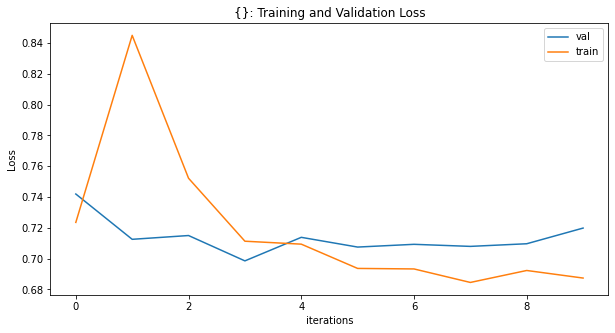

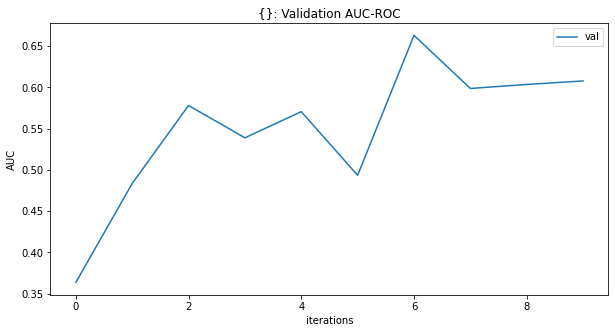

Predict: FLAIR (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 2)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,FLAIR
3,5,1,FLAIR
8,12,1,FLAIR
10,17,0,FLAIR
14,21,0,FLAIR


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,FLAIR
3,5,1,FLAIR
8,12,1,FLAIR
10,17,0,FLAIR
14,21,0,FLAIR


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7083, time: 227.00 s
[Epoch Valid: 1] loss: 0.7172, auc: 0.4476, time: 65.00 s
auc improved from 0.0000 to 0.4476. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/FLAIR-e1-loss0.717-auc0.448.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8518, time: 227.00 s
[Epoch Valid: 2] loss: 0.7202, auc: 0.5477, time: 56.00 s
auc improved from 0.4476 to 0.5477. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/FLAIR-e2-loss0.720-auc0.548.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7624, time: 218.00 s
[Epoch Valid: 3] loss: 0.7047, auc: 0.5161, time: 66.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.6989, time: 214.00 s
[Epoch Valid: 4] loss: 0.7345, auc: 0.6171, time: 71.00 s
auc improved from 

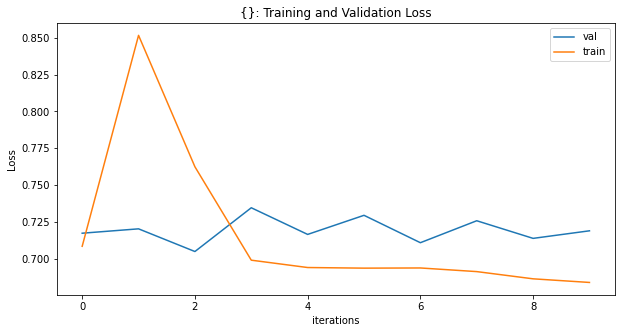

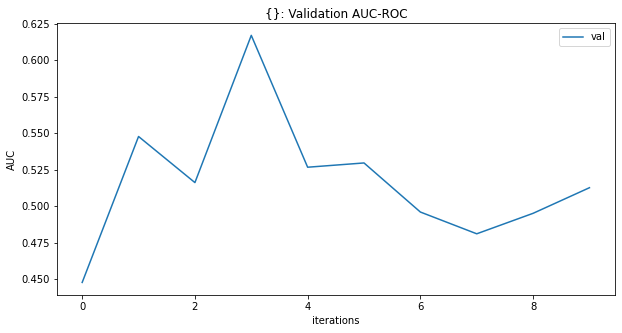

Predict: FLAIR (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,FLAIR
1,2,1,FLAIR
9,14,1,FLAIR
13,20,1,FLAIR
23,33,1,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,FLAIR
1,2,1,FLAIR
9,14,1,FLAIR
13,20,1,FLAIR
23,33,1,FLAIR


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7005, time: 220.00 s
[Epoch Valid: 1] loss: 0.7171, auc: 0.5994, time: 52.00 s
auc improved from 0.0000 to 0.5994. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/FLAIR-e1-loss0.717-auc0.599.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8548, time: 230.00 s
[Epoch Valid: 2] loss: 0.7041, auc: 0.6006, time: 58.00 s
auc improved from 0.5994 to 0.6006. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/FLAIR-e2-loss0.704-auc0.601.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7285, time: 218.00 s
[Epoch Valid: 3] loss: 0.7396, auc: 0.3657, time: 70.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7149, time: 199.00 s
[Epoch Valid: 4] loss: 0.7131, auc: 0.4876, time: 41.00 s
EPOCH: 5
Learning 

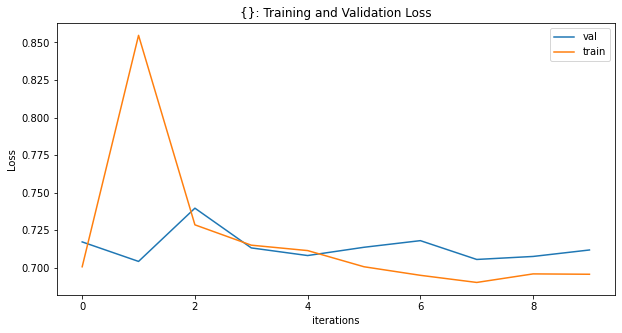

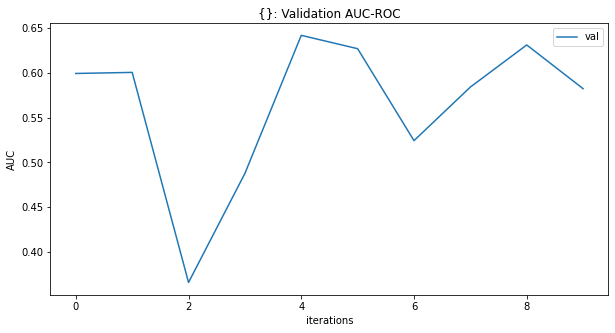

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,FLAIR
11,18,0,FLAIR
12,19,0,FLAIR
16,24,0,FLAIR
20,30,0,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,FLAIR
11,18,0,FLAIR
12,19,0,FLAIR
16,24,0,FLAIR
20,30,0,FLAIR


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7232, time: 225.00 s
[Epoch Valid: 1] loss: 0.7084, auc: 0.5410, time: 53.00 s
auc improved from 0.0000 to 0.5410. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_3/FLAIR-e1-loss0.708-auc0.541.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8682, time: 221.00 s
[Epoch Valid: 2] loss: 0.7019, auc: 0.5741, time: 57.00 s
auc improved from 0.5410 to 0.5741. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_3/FLAIR-e2-loss0.702-auc0.574.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7386, time: 244.00 s
[Epoch Valid: 3] loss: 0.7130, auc: 0.4441, time: 59.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7133, time: 210.00 s
[Epoch Valid: 4] loss: 0.7007, auc: 0.4367, time: 50.00 s
EPOCH: 5
Learning 

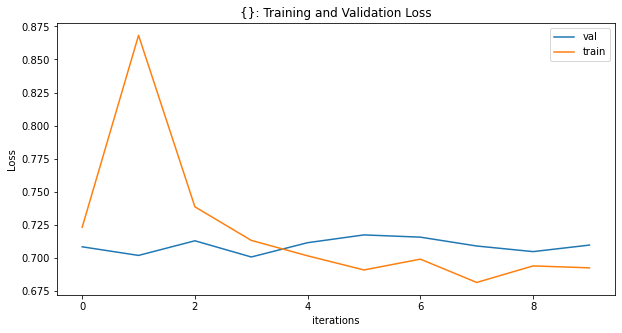

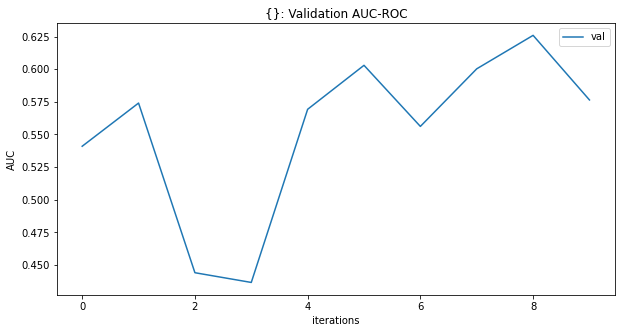

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,FLAIR
22,32,0,FLAIR
27,44,0,FLAIR
32,52,1,FLAIR
36,58,1,FLAIR


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,FLAIR
22,32,0,FLAIR
27,44,0,FLAIR
32,52,1,FLAIR
36,58,1,FLAIR


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7190, time: 255.00 s
[Epoch Valid: 1] loss: 0.7167, auc: 0.5225, time: 57.00 s
auc improved from 0.0000 to 0.5225. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_4/FLAIR-e1-loss0.717-auc0.523.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8427, time: 243.00 s
[Epoch Valid: 2] loss: 0.7091, auc: 0.5142, time: 54.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7655, time: 201.00 s
[Epoch Valid: 3] loss: 0.7040, auc: 0.5669, time: 56.00 s
auc improved from 0.5225 to 0.5669. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_4/FLAIR-e3-loss0.704-auc0.567.pth'
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7312, time: 250.00 s
[Epoch Valid: 4] loss: 0.7190, auc: 0.5541, time: 39.00 s
EPOCH: 5
Learning 

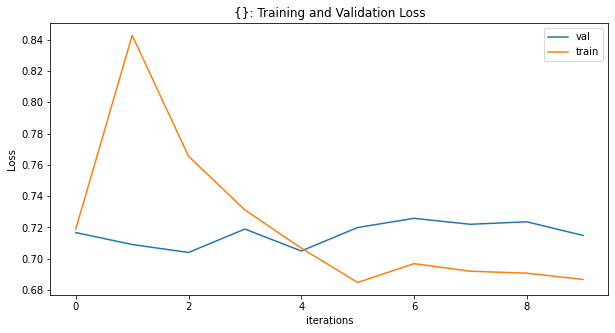

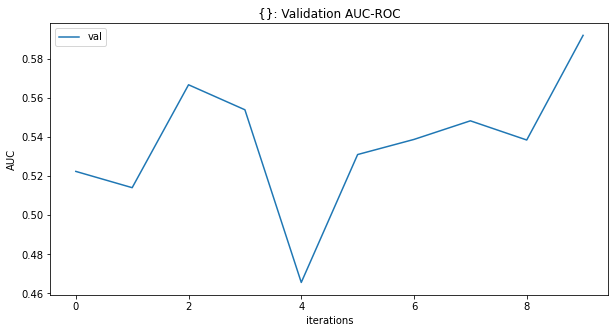

Predict: FLAIR (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: FLAIR (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1w
6,9,0,T1w
7,11,1,T1w
17,25,1,T1w
18,26,1,T1w


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1w
6,9,0,T1w
7,11,1,T1w
17,25,1,T1w
18,26,1,T1w


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7046, time: 221.00 s
[Epoch Valid: 1] loss: 0.7334, auc: 0.5279, time: 69.00 s
auc improved from 0.0000 to 0.5279. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/T1w-e1-loss0.733-auc0.528.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8880, time: 221.00 s
[Epoch Valid: 2] loss: 0.7011, auc: 0.4299, time: 63.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7779, time: 244.00 s
[Epoch Valid: 3] loss: 0.7080, auc: 0.5246, time: 55.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7212, time: 213.00 s
[Epoch Valid: 4] loss: 0.7498, auc: 0.4848, time: 64.00 s
EPOCH: 5
Learning Rate: 0.0007500001000000002
[Epoch Train: 5] loss: 0.7065, time: 224.00 s
[Epoch Valid: 5] loss: 0.7441, auc: 0.4906, time: 54.00 s
EPOCH: 6
Learning Rate: 0.0005522644107281342
[Epoch Train:

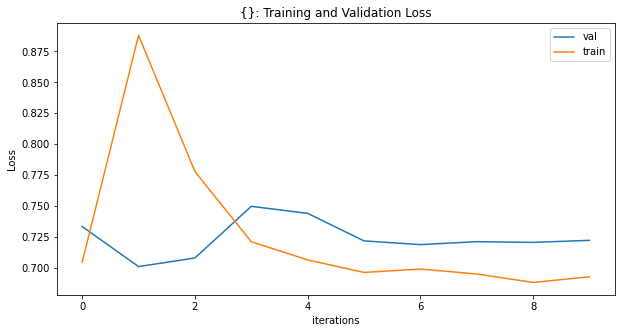

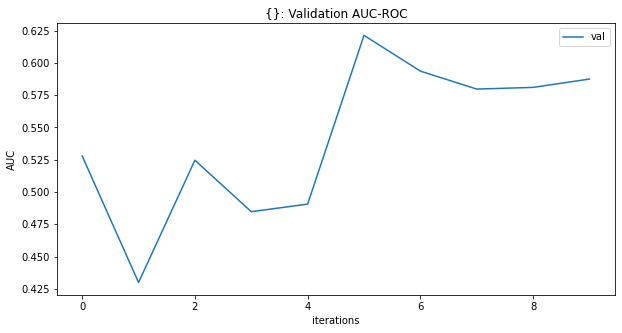

Predict: T1w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1w
3,5,1,T1w
8,12,1,T1w
10,17,0,T1w
14,21,0,T1w


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1w
3,5,1,T1w
8,12,1,T1w
10,17,0,T1w
14,21,0,T1w


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7063, time: 213.00 s
[Epoch Valid: 1] loss: 0.7042, auc: 0.6039, time: 57.00 s
auc improved from 0.0000 to 0.6039. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T1w-e1-loss0.704-auc0.604.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8864, time: 227.00 s
[Epoch Valid: 2] loss: 0.6890, auc: 0.5717, time: 59.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7578, time: 220.00 s
[Epoch Valid: 3] loss: 0.7225, auc: 0.5790, time: 65.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7118, time: 221.00 s
[Epoch Valid: 4] loss: 0.6946, auc: 0.6045, time: 58.00 s
auc improved from 0.6039 to 0.6045. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T1w-e4-loss0.695-auc0.605.pth'
EPOCH: 5
Learning Rate

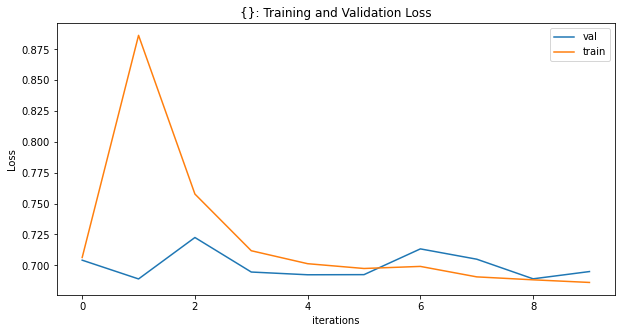

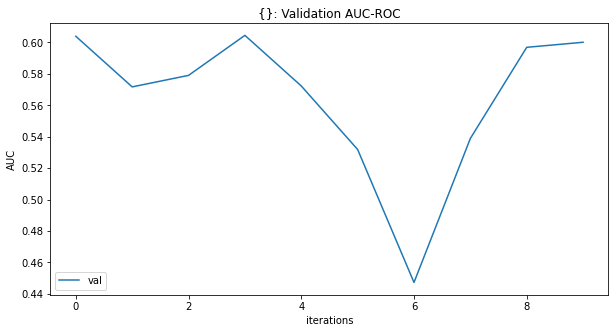

Predict: T1w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1w
1,2,1,T1w
9,14,1,T1w
13,20,1,T1w
23,33,1,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1w
1,2,1,T1w
9,14,1,T1w
13,20,1,T1w
23,33,1,T1w


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7103, time: 228.00 s
[Epoch Valid: 1] loss: 0.7007, auc: 0.4870, time: 60.00 s
auc improved from 0.0000 to 0.4870. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T1w-e1-loss0.701-auc0.487.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8778, time: 219.00 s
[Epoch Valid: 2] loss: 0.7180, auc: 0.5198, time: 42.00 s
auc improved from 0.4870 to 0.5198. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T1w-e2-loss0.718-auc0.520.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7854, time: 241.00 s
[Epoch Valid: 3] loss: 0.7081, auc: 0.5472, time: 65.00 s
auc improved from 0.5198 to 0.5472. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T1w-e3-loss0.70

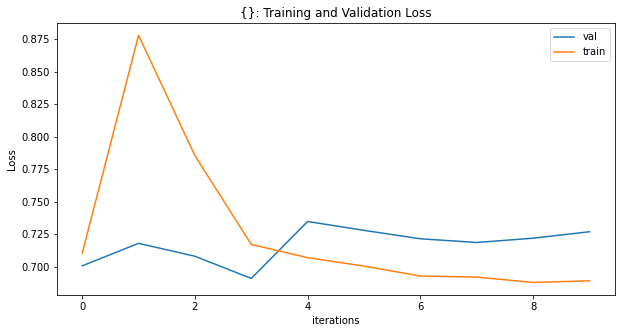

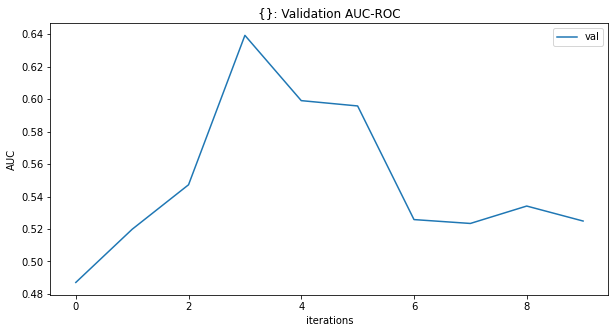

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1w
11,18,0,T1w
12,19,0,T1w
16,24,0,T1w
20,30,0,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1w
11,18,0,T1w
12,19,0,T1w
16,24,0,T1w
20,30,0,T1w


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.6957, time: 247.00 s
[Epoch Valid: 1] loss: 0.7024, auc: 0.6060, time: 56.00 s
auc improved from 0.0000 to 0.6060. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_3/T1w-e1-loss0.702-auc0.606.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8770, time: 234.00 s
[Epoch Valid: 2] loss: 0.7224, auc: 0.4271, time: 50.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7392, time: 246.00 s
[Epoch Valid: 3] loss: 0.7110, auc: 0.4569, time: 65.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7370, time: 235.00 s
[Epoch Valid: 4] loss: 0.7028, auc: 0.4915, time: 56.00 s
EPOCH: 5
Learning Rate: 0.0007500001000000002
[Epoch Train: 5] loss: 0.7057, time: 258.00 s
[Epoch Valid: 5] loss: 0.7356, auc: 0.5404, time: 55.00 s
EPOCH: 6
Learning Rate: 0.0005522644107281342
[Epoch Train:

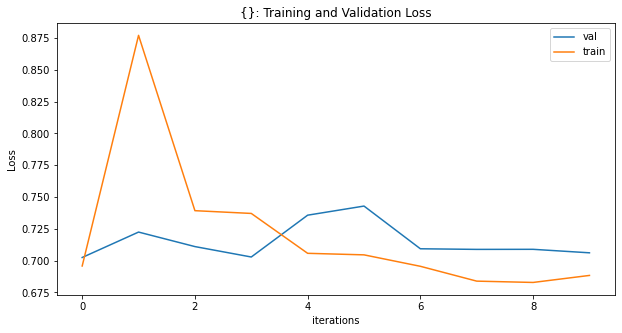

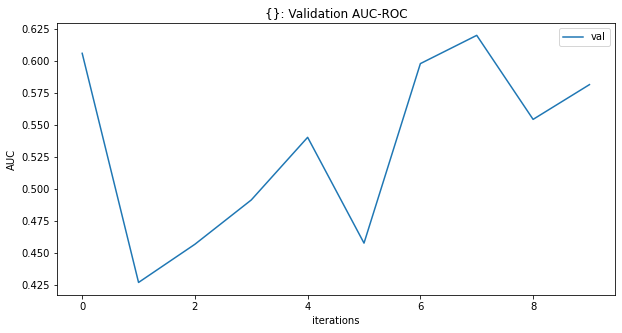

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1w
22,32,0,T1w
27,44,0,T1w
32,52,1,T1w
36,58,1,T1w


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1w
22,32,0,T1w
27,44,0,T1w
32,52,1,T1w
36,58,1,T1w


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7216, time: 237.00 s
[Epoch Valid: 1] loss: 0.6995, auc: 0.6179, time: 69.00 s
auc improved from 0.0000 to 0.6179. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_4/T1w-e1-loss0.700-auc0.618.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8481, time: 244.00 s
[Epoch Valid: 2] loss: 0.7152, auc: 0.5568, time: 64.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7617, time: 224.00 s
[Epoch Valid: 3] loss: 0.7176, auc: 0.4674, time: 44.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7075, time: 244.00 s
[Epoch Valid: 4] loss: 0.7245, auc: 0.3967, time: 51.00 s
EPOCH: 5
Learning Rate: 0.0007500001000000002
[Epoch Train: 5] loss: 0.6874, time: 247.00 s
[Epoch Valid: 5] loss: 0.7024, auc: 0.5268, time: 50.00 s
EPOCH: 6
Learning Rate: 0.0005522644107281342
[Epoch Train:

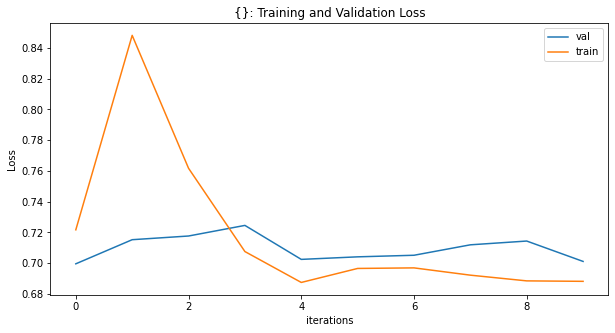

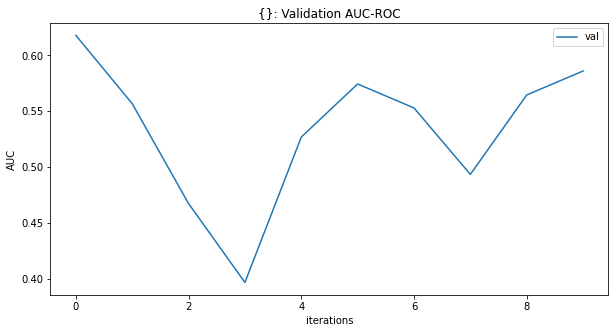

Predict: T1w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1wCE
6,9,0,T1wCE
7,11,1,T1wCE
17,25,1,T1wCE
18,26,1,T1wCE


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T1wCE
6,9,0,T1wCE
7,11,1,T1wCE
17,25,1,T1wCE
18,26,1,T1wCE


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7004, time: 216.00 s
[Epoch Valid: 1] loss: 0.7005, auc: 0.4463, time: 66.00 s
auc improved from 0.0000 to 0.4463. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/T1wCE-e1-loss0.701-auc0.446.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8512, time: 229.00 s
[Epoch Valid: 2] loss: 0.7495, auc: 0.4457, time: 60.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7394, time: 242.00 s
[Epoch Valid: 3] loss: 0.7095, auc: 0.4393, time: 64.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7106, time: 238.00 s
[Epoch Valid: 4] loss: 0.7068, auc: 0.6284, time: 61.00 s
auc improved from 0.4463 to 0.6284. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/T1wCE-e4-loss0.707-auc0.628.pth'
EPOCH: 5
Learning 

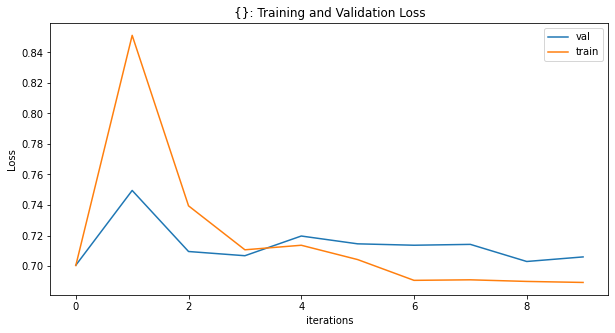

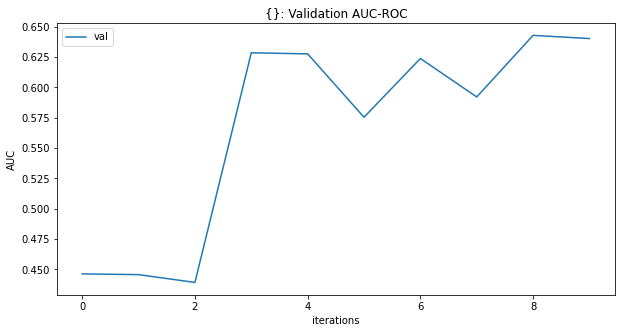

Predict: T1wCE (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1wCE
3,5,1,T1wCE
8,12,1,T1wCE
10,17,0,T1wCE
14,21,0,T1wCE


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T1wCE
3,5,1,T1wCE
8,12,1,T1wCE
10,17,0,T1wCE
14,21,0,T1wCE


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7156, time: 242.00 s
[Epoch Valid: 1] loss: 0.7194, auc: 0.4640, time: 63.00 s
auc improved from 0.0000 to 0.4640. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T1wCE-e1-loss0.719-auc0.464.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8333, time: 247.00 s
[Epoch Valid: 2] loss: 0.7553, auc: 0.4681, time: 52.00 s
auc improved from 0.4640 to 0.4681. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T1wCE-e2-loss0.755-auc0.468.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7496, time: 226.00 s
[Epoch Valid: 3] loss: 0.7411, auc: 0.5037, time: 64.00 s
auc improved from 0.4681 to 0.5037. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T1wCE-e3-lo

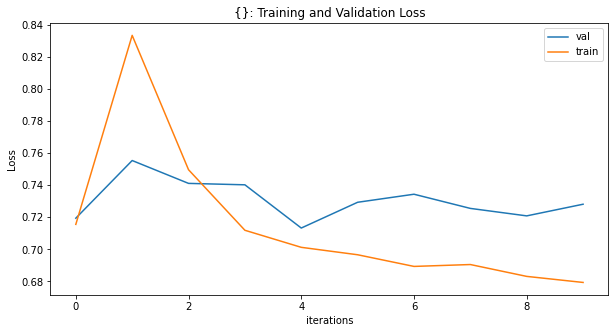

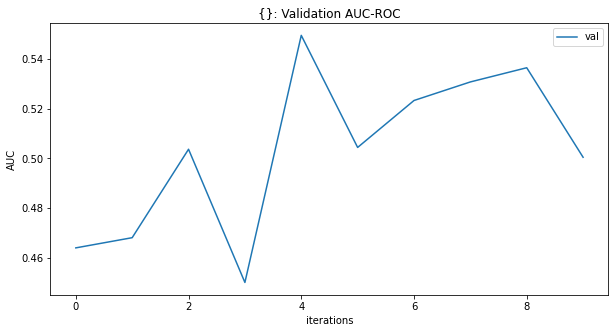

Predict: T1wCE (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1wCE
1,2,1,T1wCE
9,14,1,T1wCE
13,20,1,T1wCE
23,33,1,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T1wCE
1,2,1,T1wCE
9,14,1,T1wCE
13,20,1,T1wCE
23,33,1,T1wCE


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7148, time: 230.00 s
[Epoch Valid: 1] loss: 0.7133, auc: 0.4846, time: 47.00 s
auc improved from 0.0000 to 0.4846. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T1wCE-e1-loss0.713-auc0.485.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8657, time: 216.00 s
[Epoch Valid: 2] loss: 0.6966, auc: 0.5258, time: 58.00 s
auc improved from 0.4846 to 0.5258. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T1wCE-e2-loss0.697-auc0.526.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7410, time: 257.00 s
[Epoch Valid: 3] loss: 0.7706, auc: 0.4686, time: 56.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7180, time: 238.00 s
[Epoch Valid: 4] loss: 0.7709, auc: 0.4694, time: 62.00 s
EPOCH: 5
Learning 

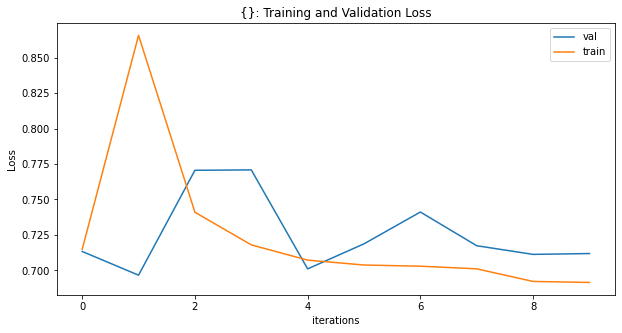

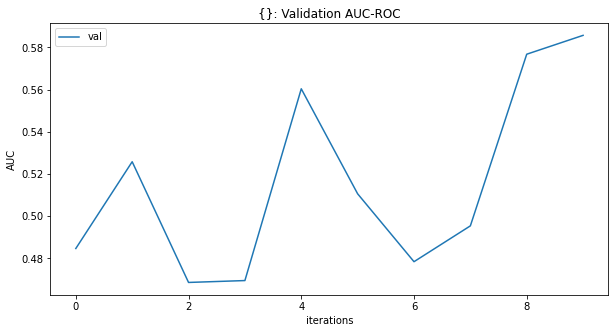

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1wCE
11,18,0,T1wCE
12,19,0,T1wCE
16,24,0,T1wCE
20,30,0,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T1wCE
11,18,0,T1wCE
12,19,0,T1wCE
16,24,0,T1wCE
20,30,0,T1wCE


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7167, time: 231.00 s
[Epoch Valid: 1] loss: 0.7043, auc: 0.5857, time: 58.00 s
auc improved from 0.0000 to 0.5857. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_3/T1wCE-e1-loss0.704-auc0.586.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8921, time: 226.00 s
[Epoch Valid: 2] loss: 0.7122, auc: 0.5502, time: 56.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7530, time: 210.00 s
[Epoch Valid: 3] loss: 0.7081, auc: 0.5633, time: 56.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.6938, time: 219.00 s
[Epoch Valid: 4] loss: 0.7069, auc: 0.6004, time: 62.00 s
auc improved from 0.5857 to 0.6004. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_3/T1wCE-e4-loss0.707-auc0.600.pth'
EPOCH: 5
Learning 

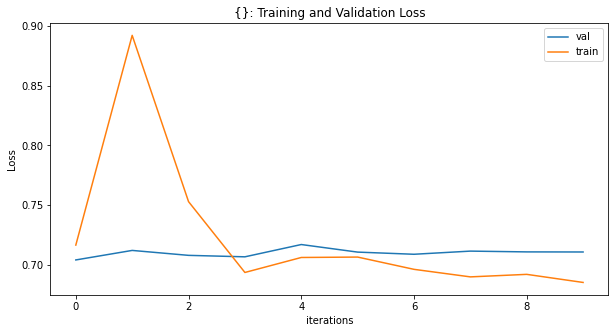

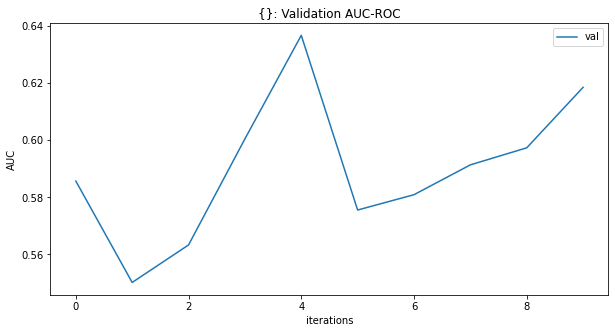

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1wCE
22,32,0,T1wCE
27,44,0,T1wCE
32,52,1,T1wCE
36,58,1,T1wCE


466


,BraTS21ID,MGMT_value,MRI_Type
15,22,0,T1wCE
22,32,0,T1wCE
27,44,0,T1wCE
32,52,1,T1wCE
36,58,1,T1wCE


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7163, time: 233.00 s
[Epoch Valid: 1] loss: 0.7247, auc: 0.5613, time: 49.00 s
auc improved from 0.0000 to 0.5613. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_4/T1wCE-e1-loss0.725-auc0.561.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8843, time: 256.00 s
[Epoch Valid: 2] loss: 0.7119, auc: 0.4462, time: 58.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7256, time: 253.00 s
[Epoch Valid: 3] loss: 0.7188, auc: 0.5550, time: 56.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7066, time: 239.00 s
[Epoch Valid: 4] loss: 0.7155, auc: 0.5663, time: 48.00 s
auc improved from 0.5613 to 0.5663. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_4/T1wCE-e4-loss0.715-auc0.566.pth'
EPOCH: 5
Learning 

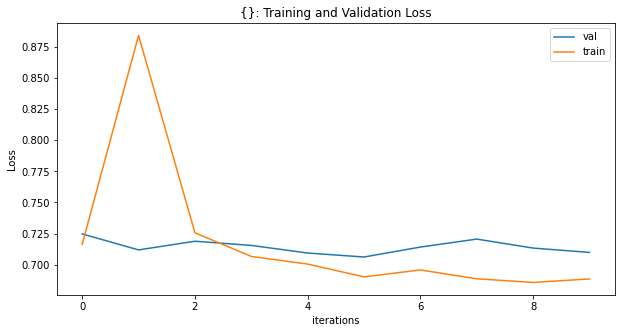

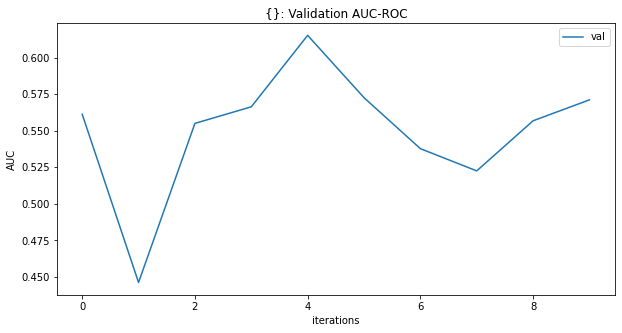

Predict: T1wCE (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T1wCE (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T2w
6,9,0,T2w
7,11,1,T2w
17,25,1,T2w
18,26,1,T2w


465


,BraTS21ID,MGMT_value,MRI_Type
5,8,1,T2w
6,9,0,T2w
7,11,1,T2w
17,25,1,T2w
18,26,1,T2w


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7100, time: 225.00 s
[Epoch Valid: 1] loss: 0.7349, auc: 0.4176, time: 62.00 s
auc improved from 0.0000 to 0.4176. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/T2w-e1-loss0.735-auc0.418.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8610, time: 238.00 s
[Epoch Valid: 2] loss: 0.7018, auc: 0.4111, time: 68.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7521, time: 218.00 s
[Epoch Valid: 3] loss: 0.6973, auc: 0.5804, time: 56.00 s
auc improved from 0.4176 to 0.5804. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_0/T2w-e3-loss0.697-auc0.580.pth'
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7175, time: 217.00 s
[Epoch Valid: 4] loss: 0.7146, auc: 0.5270, time: 60.00 s
EPOCH: 5
Learning Rate

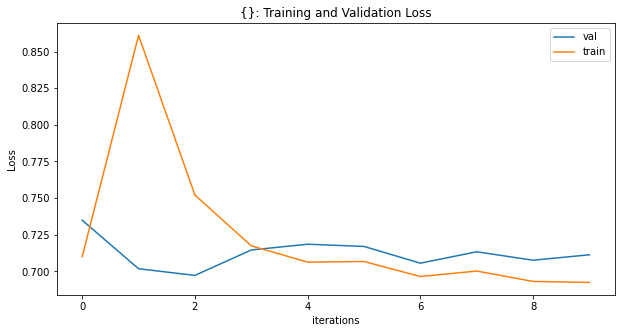

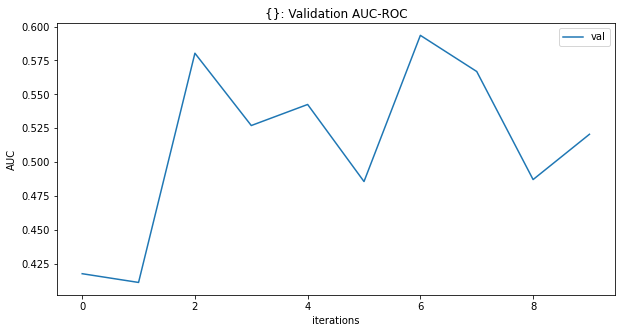

Predict: T2w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(465, 3) (117, 3)


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T2w
3,5,1,T2w
8,12,1,T2w
10,17,0,T2w
14,21,0,T2w


465


,BraTS21ID,MGMT_value,MRI_Type
2,3,0,T2w
3,5,1,T2w
8,12,1,T2w
10,17,0,T2w
14,21,0,T2w


117
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7152, time: 232.00 s
[Epoch Valid: 1] loss: 0.7288, auc: 0.4160, time: 61.00 s
auc improved from 0.0000 to 0.4160. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T2w-e1-loss0.729-auc0.416.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8698, time: 225.00 s
[Epoch Valid: 2] loss: 0.7273, auc: 0.4997, time: 67.00 s
auc improved from 0.4160 to 0.4997. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_1/T2w-e2-loss0.727-auc0.500.pth'
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7499, time: 212.00 s
[Epoch Valid: 3] loss: 0.7251, auc: 0.4889, time: 60.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7147, time: 229.00 s
[Epoch Valid: 4] loss: 0.7292, auc: 0.5615, time: 53.00 s
auc improved from 0.49

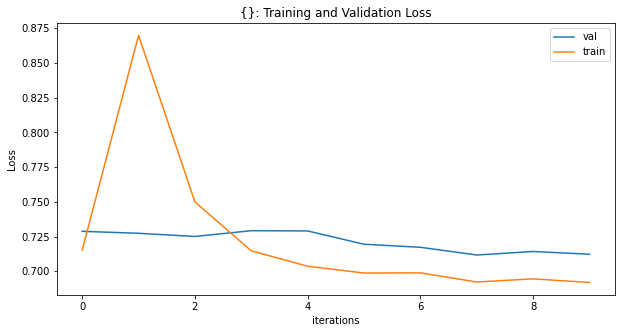

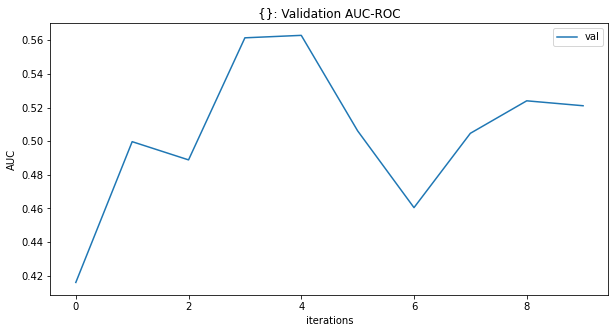

Predict: T2w (117, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T2w
1,2,1,T2w
9,14,1,T2w
13,20,1,T2w
23,33,1,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
0,0,1,T2w
1,2,1,T2w
9,14,1,T2w
13,20,1,T2w
23,33,1,T2w


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7039, time: 214.00 s
[Epoch Valid: 1] loss: 0.7239, auc: 0.5180, time: 59.00 s
auc improved from 0.0000 to 0.5180. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T2w-e1-loss0.724-auc0.518.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999
[Epoch Train: 2] loss: 0.8798, time: 238.00 s
[Epoch Valid: 2] loss: 0.7302, auc: 0.4793, time: 56.00 s
EPOCH: 3
Learning Rate: 0.0009890738047373827
[Epoch Train: 3] loss: 0.7502, time: 239.00 s
[Epoch Valid: 3] loss: 0.7133, auc: 0.4930, time: 46.00 s
EPOCH: 4
Learning Rate: 0.000904508535384075
[Epoch Train: 4] loss: 0.7180, time: 275.00 s
[Epoch Valid: 4] loss: 0.7172, auc: 0.5383, time: 63.00 s
auc improved from 0.5180 to 0.5383. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_2/T2w-e4-loss0.717-auc0.538.pth'
EPOCH: 5
Learning Rate

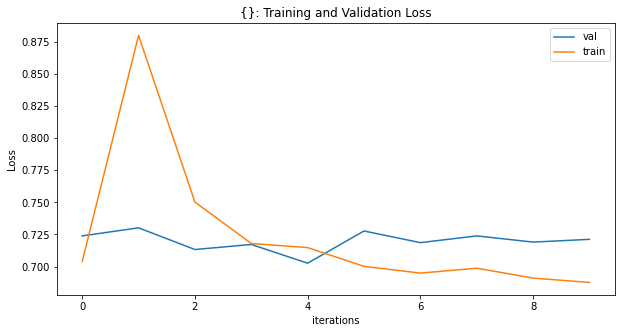

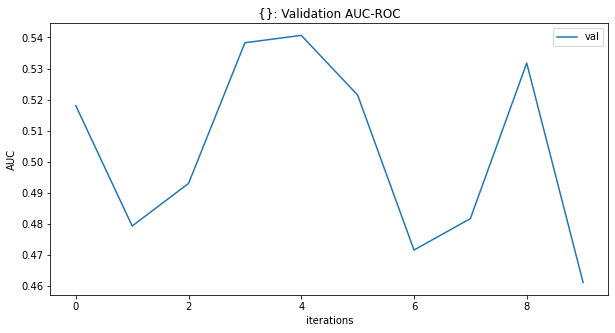

Predict: T2w (116, 2)


/home/christian/miniconda/envs/pytorch/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Predict: T2w (87, 3)
(466, 3) (116, 3)


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T2w
11,18,0,T2w
12,19,0,T2w
16,24,0,T2w
20,30,0,T2w


466


,BraTS21ID,MGMT_value,MRI_Type
4,6,1,T2w
11,18,0,T2w
12,19,0,T2w
16,24,0,T2w
20,30,0,T2w


116
EPOCH: 1
Learning Rate: 3.9999999999999996e-05
[Epoch Train: 1] loss: 0.7189, time: 246.00 s
[Epoch Valid: 1] loss: 0.7124, auc: 0.5583, time: 65.00 s
auc improved from 0.0000 to 0.5583. Saved model to 'experiments/patch_seresnext50_3fold_stacking/experiments/patch_seresnext50_3fold_stacking/models/fold_3/T2w-e1-loss0.712-auc0.558.pth'
EPOCH: 2
Learning Rate: 0.0007599999999999999


In [ ]:
%%time

oof_train = []
oof_test = []
modelfiles = []

for mri_type in mri_types:
    trn, tst, modelfile = train_mri_type(df, df_test, mri_type, rkf)
    oof_train.append(trn)
    oof_test.append(tst)
    modelfiles.append(modelfile)

In [ ]:
np.save(f"{experiment_folder}/oof_train.npy", oof_train)
np.save(f"{experiment_folder}/oof_test.npy", oof_test)

In [ ]:
oof_train = np.load(f"{experiment_folder}/oof_train.npy")
oof_test = np.load(f"{experiment_folder}/oof_test.npy")

In [ ]:
x_train = np.swapaxes(np.array(oof_train), 0, 1)
x_test = np.swapaxes(np.array(oof_test), 0, 1)

In [ ]:
len(df), len(x_train), len(x_test)

In [ ]:
df_test = pd.read_csv(f"{data_directory}/sample_submission.csv")

In [ ]:
for i, mri_type in enumerate(mri_types):
    df[f"level0_{mri_type}_preds"] = x_train[:, i]
    df_test[f"level0_{mri_type}_preds"] = x_test[:, i]

In [ ]:
y = df["MGMT_value"].values
X = df.drop(["MGMT_value"], axis=1)

In [ ]:
if "BraTS21ID" in X.columns:
    X = X.drop(["BraTS21ID"], axis=1)

In [ ]:
X.head()

In [ ]:
params = {
    'learning_rate': [0.005, 0.002, 0.0001],
    'n_estimators': [1000, 2000, 5000],
    'min_child_weight': [1, 10, 20],
    'gamma': [1, 2, 5],
    'subsample': [0.9, 1.0], # 0.6, 0.8, 
    'colsample_bytree': [0.9, 1.0],
    'max_depth': [2, 3, 4, 5]
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
gbc = xgb.XGBClassifier(
    # objective='binary:logistic',
    # use_label_encoder=False
)

In [ ]:
from sklearn.metrics import make_scorer

In [ ]:
roc_auc_sklearn = make_scorer(roc_auc_score)

In [ ]:
param_comb = 100

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=52)

random_search = RandomizedSearchCV(
    gbc,
    param_distributions=params,
    n_iter=param_comb,
    scoring=roc_auc_sklearn,
    n_jobs=8,
    cv=skf.split(X, y),
    random_state=21,
)

random_search.fit(X, y)

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv(f'{experiment_folder}/xgb-random-grid-search-results-01.csv', index=False)

In [ ]:
results[results["rank_test_score"] < 8].sort_values("rank_test_score")

In [ ]:
x_test = df_test.copy()

if "BraTS21ID" in x_test.columns:
    x_test = x_test.drop(["BraTS21ID"], axis=1)
if "MGMT_value" in x_test.columns:
    x_test = x_test.drop(["MGMT_value"], axis=1)

In [ ]:
test_preds = random_search.predict_proba(x_test)

In [ ]:
test_preds = test_preds[:,1]

In [ ]:
test_preds

In [ ]:
np.unique(test_preds)

In [ ]:
# auc = roc_auc_score(y_valid, val_preds)
# print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(test_preds)

**Submission**

In [ ]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv")
submission["MGMT_value"] = test_preds
submission.to_csv(f"{experiment_folder}/submission_stacking.csv")

In [ ]:
tmp_pred = np.array(oof_test).mean(0)

In [ ]:
tmp_pred

In [ ]:
submission = pd.read_csv(f"{data_directory}/sample_submission.csv")
submission["MGMT_value"] = tmp_pred
submission.to_csv(f"{experiment_folder}/submission_mean.csv")